# Дополнительное домашнее задание №3*

Это просто вторая часть из [лабараторной работы №3](https://github.com/ml-mipt/ml-mipt/blob/b9f61d59cadbe825f476befa954d75ebbb30c30e/homeworks/Lab3_DL/Lab3_DL.ipynb) с курса ФИВТа

Решенный ноутбук нужно загрузить в [форму](http://bit.ly/dafe_hw)  
Дедлайн: __24.05.2019__

В этой части задания мы научимся генерировать текст с помощью нейронных сетей. Конкретнее, обучим нейронную сеть на сонетах Шекспира и попросим нейросеть написать свой сонет.

Генерация текста обычно включает в себя следующие шаги:
    
1. Загрузка данных.
2. Создание словарей слов/символов.
3. Препроцессинг данных.
4. Обучение модели (нейросети).
5. Генерация нового текста.


## Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [1]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [2]:
# Объедините все строки в одну и приведите к нижнему регистру.
# Результат запишите в переменную text.
import string

# Your great code here
text = [line.lower() for line in text]
text = ''.join(text)

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('Отлично!')

Отлично!


Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [25]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

words = list(set(tokenizer.tokenize(text)))
tokens = np.array(list(set(text)))

In [26]:
len(tokens)

38

Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [27]:
# словарь вида <индекс>:<символ>
# Your great code here
idx_to_token = {i:word for i, word in enumerate(tokens)}

# словарь вида <символ>:<индекс>
# Your great code here
token_to_idx = {word:i for i, word in enumerate(tokens)}

In [28]:
assert len(tokens) == len(token_to_idx), "dictionaries must have same size"
num_tokens = len(tokens)
for i in range(num_tokens):
    assert token_to_idx[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [29]:
import numpy as np

def to_matrix(names, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [41]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(tokens)

ModuleNotFoundError: No module named 'sklearn'

In [38]:
tokens.shape

(38,)

In [39]:
one_hot_encode(tokens, len(tokens))

IndexError: arrays used as indices must be of integer (or boolean) type

*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*


## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

In [11]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [12]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat((x_emb, h_prev), dim=1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [13]:
char_rnn = CharRNNCell()

In [14]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [15]:
batch_ix = to_matrix(words[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

/home/keleas/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [16]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

loss = -logp_next.mean()

In [17]:
loss.backward()

In [18]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

In [19]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

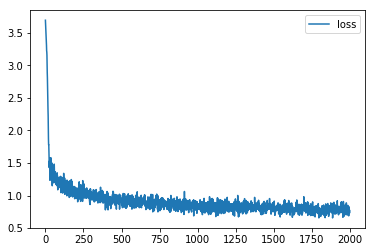

In [21]:
import matplotlib.pyplot as plt

MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(words, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    #<YOUR CODE>
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    #<YOUR CODE>
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [40]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [41]:
for _ in range(10):
    print(generate_sample(char_rnn))

In [42]:

for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase='kek'))

kekest          
keks            
keking          
kek             
kekanged        
kekrouss        
kek             
kekirn          
keking          
keking          
kek             
kekind          
kekshe          
kekndale        
keks            
keks            
keknedsy        
keksens         
kek             
keks            
kekness         
kekger          
kek             
kekstry         
kek             
kekth           
kekvi           
kekne           
kek             
kek             
kek             
keknth          
keking          
kekche          
keks            
kek             
kekele          
kekes           
kekidess        
keking          
keks            
keky            
kek             
kek             
kekt            
kekbs-          
keking          
keks            
kekser          
kekts           


Постройте график функции потерь в зависимости от номера эпохи.

In [ ]:
# Your plot code here

In [ ]:
# Пример сгенерированного текста. Функция `generate_text` отсутствует в коде выше.
# print(generate_text(length=500, temperature=0.2))

## Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

Снова постройте график функции потерь от числа эпох. Стал ли финальный loss лучше?

In [ ]:
# Your beautiful code here

Сгенерируйте текст с помощью обученной сети для различных значений параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]` ("температуры" при генерации). Оцените результаты визуально, попробуйте их проинтерпретировать.

In [ ]:
# Text generation with different tempearature values here

Здесь можно оставить свои рассуждения касательно интерпретации результатов.

## Сохранение и загрузка модели

Сохраните обученную модель на диск, затем загрузите ее и сгенерируйте текст. Примеры доступны по [ссылке](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

## Полезные ссылки
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Статья Андрея Карпатого про RNN. </a> В качестве примеров рассматриваются задачи генерации Шекспировских текстов, Latex формул, Linux Source Code и детских имен.
2. <a href='https://github.com/karpathy/char-rnn'> Репозиторий с кодом по char-rnn </a> (тоже за авторством Андрея Карпатого)
3. Полезный репозиторий по PyTorch: [ссылка](https://github.com/spro/practical-pytorch`)